# Install & imports

In [1]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;

# Modeling
import xgboost as xgb
import lightgbm as lgb
import torch

# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 100)

In [2]:
DEBUG = False # False/True

In [3]:
# GPU or CPU use for model
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
# Helper functions
def display_df(df, name):
    '''Display df shape and first row '''
    PrintColor(text = f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n ===> First row:')
    display(df.head(1))

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    '''Prints color outputs using colorama of a text string'''
    print(style + color + text + Style.RESET_ALL); 

In [5]:
DATA_DIR = "C:\\projects\\predict-energy\\data\\"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")

In [6]:
# Location from https://www.kaggle.com/datasets/michaelo/fabiendaniels-mapping-locations-and-county-codes/data
location = (pd.read_csv(r"C:\projects\predict-energy\data\county_lon_lats.csv")
            .drop(columns = ["Unnamed: 0"])
           )

In [7]:
display_df(train, 'train')
display_df(client, 'client')
display_df(historical_weather, 'historical weather')
display_df(forecast_weather, 'forecast weather')
display_df(electricity, 'electricity prices')
display_df(gas, 'gas prices')
display_df(location, 'location data')

train data has 2018352 rows and 9 columns. 
 ===> First row:


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


client data has 41919 rows and 7 columns. 
 ===> First row:


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


historical weather data has 1710802 rows and 18 columns. 
 ===> First row:


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0


forecast weather data has 3424512 rows and 18 columns. 
 ===> First row:


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


electricity prices data has 15286 rows and 4 columns. 
 ===> First row:


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


gas prices data has 637 rows and 5 columns. 
 ===> First row:


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


location data data has 75 rows and 3 columns. 
 ===> First row:


,county,longitude,latitude
0,0,24.2,59.1


In [8]:
# See county codes
with open(DATA_DIR + 'county_id_to_name_map.json') as f:
    county_codes = json.load(f)
pd.DataFrame(county_codes, index=[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,HARJUMAA,HIIUMAA,IDA-VIRUMAA,JÄRVAMAA,JÕGEVAMAA,LÄÄNE-VIRUMAA,LÄÄNEMAA,PÄRNUMAA,PÕLVAMAA,RAPLAMAA,SAAREMAA,TARTUMAA,UNKNOWN,VALGAMAA,VILJANDIMAA,VÕRUMAA


In [9]:
# pd.DataFrame(train[train['is_consumption']==0].target.describe(percentiles = [0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])).round(2).T
# pd.DataFrame(train[train['is_consumption']==1].target.describe(percentiles = [0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])).round(2).T

# Data processing

In [10]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''📊Create features for main data (test or train) set📊'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''⌛🌤️ Create historical weather features 🌤️⌛'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''🔮🌤️ Create forecast weather features 🌤️🔮'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''⚡ Create electricity prices features ⚡'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''⛽ Create gas prices features ⛽'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # 🔗 Merge all datasets into one df 🔗
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df

In [11]:
def create_revealed_targets_train(data, N_day_lags):
    '''🎯 Create past revealed_targets for train set based on number of day lags N_day_lags 🎯 '''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy()
    
    # Create revealed targets for all day lags
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago')
                         )
    return data

In [12]:
%%time
# Create all features
N_day_lags = 15 # Specify how many days we want to go back (at least 2)

FeatureProcessor = FeatureProcessorClass()

data = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity.copy(),
                      gas = gas.copy(),
                     )

df = create_revealed_targets_train(data.copy(), 
                                  N_day_lags = N_day_lags)

CPU times: total: 33.2 s
Wall time: 51.4 s


In [13]:
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week,eic_count_client,installed_capacity_client,date_client,temperature_h_mean,dewpoint_h_mean,rain_h_mean,snowfall_h_mean,surface_pressure_h_mean,cloudcover_total_h_mean,cloudcover_low_h_mean,cloudcover_mid_h_mean,cloudcover_high_h_mean,windspeed_10m_h_mean,winddirection_10m_h_mean,shortwave_radiation_h_mean,direct_solar_radiation_h_mean,diffuse_radiation_h_mean,hour_h,hours_ahead_f_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electricity,euros_per_mwh_electricity,origin_date_electricity,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,target_8_days_ago,target_9_days_ago,target_10_days_ago,target_11_days_ago,target_12_days_ago,target_13_days_ago,target_14_days_ago,target_15_days_ago
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,2023,2,5,22,23,151,31,2,15.0,620.0,2023-05-29,11.18,6.98,0.0,0.0,1003.74,21.2,2.8,16.4,29.8,1.772222,170.0,0.0,0.0,0.0,23.0,45.0,11.484033,6.748584,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,188.167,173.048,184.072,188.122,356.783,415.530,182.342,459.845,162.786,186.582,191.756,181.415,421.707,410.259
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,2023,2,5,22,23,151,31,2,20.0,624.5,2023-05-29,11.18,6.98,0.0,0.0,1003.74,21.2,2.8,16.4,29.8,1.772222,170.0,0.0,0.0,0.0,23.0,45.0,11.484033,6.748584,0.453412,0.045816,0.017661,0.488751,3.560166,-0.286433,-0.335111,0.0,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2018349,15,1,

# XGBoost single fold

In [14]:
#### Create single fold split ######
# Remove empty target row
target = 'target'
df = df[df[target].notnull()].reset_index(drop=True)

In [ ]:
# Define total data points
total_data_points = 637

# Split sizes
train_size = int(total_data_points * 0.8)  # 80% for training (509)
val_size = int(total_data_points * 0.15)    # 10% for validation (96)
test_size = total_data_points - train_size - val_size  # Remaining 10% for testing (32)

# Train Block ID for the first 509 data points
train_block_id = list(range(0, train_size))  # First 509 for training

# Validation Block ID for the next 64 data points
val_block_id = list(range(train_size, train_size + val_size))  # Next 64 for validation

# Test Block ID for the remaining 64 data points
test_block_id = list(range(train_size + val_size, total_data_points))  # Last 64 for testing

# Split the data accordingly
train_data = df[df['data_block_id'].isin(train_block_id)]
val_data = df[df['data_block_id'].isin(val_block_id)]
test_data = df[df['data_block_id'].isin(test_block_id)]

# Check the sizes of each split
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 1607748
Validation set size: 300972
Test set size: 105984


In [16]:
# Remove columns for features
no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
               ]

remove_columns = [col for col in df.columns for no_feature in no_features if no_feature in col]
remove_columns.append(target)
features = [col for col in df.columns if col not in remove_columns]
PrintColor(f'There are {len(features)} features: {features}')

There are 59 features: ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 'lowest_price_per_mwh_gas', 'highest_

In [17]:
clf = xgb.XGBRegressor(
                        device = device,
                        enable_categorical=True,
                        objective = 'reg:absoluteerror',
                        n_estimators = 2 if DEBUG else 1500,
                        early_stopping_rounds=100
                       )

In [18]:
clf.fit(X = train_data[features], 
        y = train_data[target], 
        eval_set = [(train_data[features], train_data[target]), (val_data[features], val_data[target])], 
        verbose=True #False #True
       )

[0]	validation_0-mae:231.68173	validation_1-mae:302.12181
[1]	validation_0-mae:206.52955	validation_1-mae:273.02738
[2]	validation_0-mae:181.55089	validation_1-mae:243.33896
[3]	validation_0-mae:161.42676	validation_1-mae:217.81986
[4]	validation_0-mae:145.66832	validation_1-mae:196.84910
[5]	validation_0-mae:133.78570	validation_1-mae:182.14016
[6]	validation_0-mae:119.34816	validation_1-mae:162.51642
[7]	validation_0-mae:101.00716	validation_1-mae:141.49809
[8]	validation_0-mae:86.50961	validation_1-mae:124.14725
[9]	validation_0-mae:76.63631	validation_1-mae:110.21532
[10]	validation_0-mae:70.17706	validation_1-mae:101.11651
[11]	validation_0-mae:65.30434	validation_1-mae:93.77826
[12]	validation_0-mae:61.44179	validation_1-mae:86.82709
[13]	validation_0-mae:59.12995	validation_1-mae:82.39686
[14]	validation_0-mae:57.68407	validation_1-mae:79.60873
[15]	validation_0-mae:56.65480	validation_1-mae:78.21063
[16]	validation_0-mae:56.42303	validation_1-mae:78.00274
[17]	validation_0-mae:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=100,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
PrintColor(f'Early stopping on best iteration #{clf.best_iteration} with MAE error on validation set of {clf.best_score:.2f}')

Early stopping on best iteration #706 with MAE error on validation set of 54.59


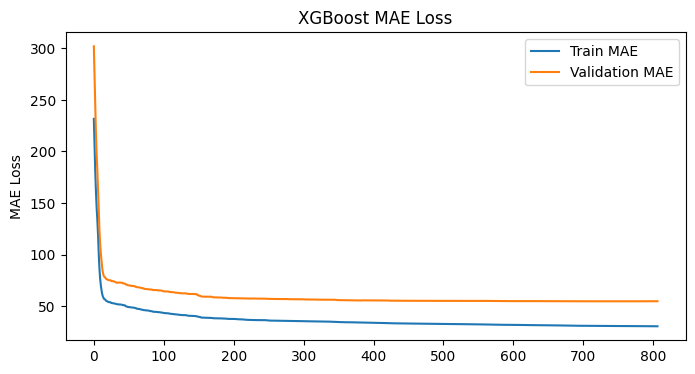

In [20]:
# Plot RMSE
results = clf.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
x_values = range(0, len(train_mae))
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x_values, train_mae, label="Train MAE")
ax.plot(x_values, val_mae, label="Validation MAE")
ax.legend()
plt.ylabel("MAE Loss")
plt.title("XGBoost MAE Loss")
plt.show()

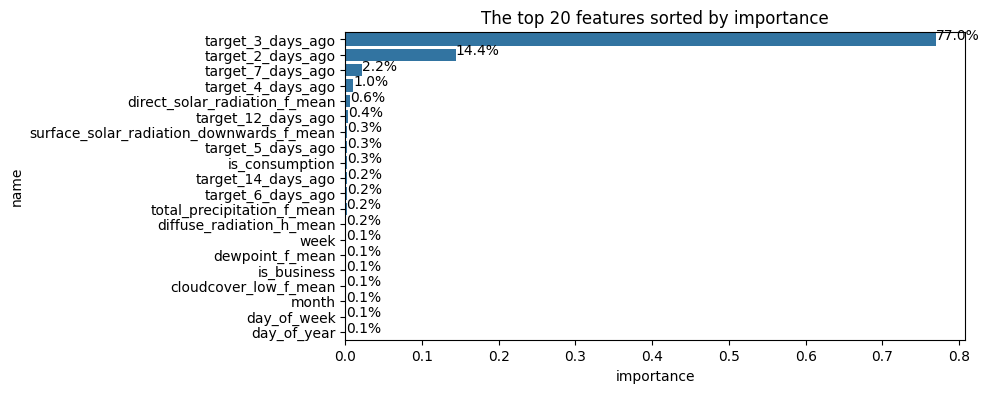

In [21]:
TOP = 20
importance_data = pd.DataFrame({'name': clf.feature_names_in_, 'importance': clf.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(data=importance_data[:TOP],
            x = 'importance',
            y = 'name'
        )
patches = ax.patches
count = 0
for patch in patches:
    height = patch.get_height() 
    width = patch.get_width()
    perc = 100*importance_data['importance'].iloc[count]#100*width/len(importance_data)
    ax.text(width, patch.get_y() + height/2, f'{perc:.1f}%')
    count+=1
    
plt.title(f'The top {TOP} features sorted by importance')
plt.show()

In [22]:
importance_data[importance_data['importance']<0.0005].name.values

array(['target_11_days_ago', 'prediction_unit_id', 'target_15_days_ago',
       'target_10_days_ago', 'winddirection_10m_h_mean',
       'direct_solar_radiation_h_mean',
       '10_metre_v_wind_component_f_mean', 'cloudcover_mid_f_mean',
       'dewpoint_h_mean', 'euros_per_mwh_electricity',
       'surface_pressure_h_mean', 'cloudcover_low_h_mean',
       'cloudcover_high_f_mean', 'cloudcover_total_h_mean',
       'snowfall_h_mean', 'quarter', 'windspeed_10m_h_mean',
       'cloudcover_high_h_mean', 'cloudcover_mid_h_mean', 'rain_h_mean'],
      dtype=object)

# Submit

In [23]:
# Get the features for the test set
X_test = test_data[features]

# Make predictions on the test set
test_predictions = clf.predict(X_test)

# Add predictions as a new column to the test_data
test_data['predicted_target'] = test_predictions

# Compare the actual target values with the predicted ones
comparison = test_data[['row_id', target, 'predicted_target']]

# Calculate the error (difference between actual and predicted)
comparison['error'] = comparison[target] - comparison['predicted_target']

# Calculate the absolute error
comparison['absolute_error'] = comparison['error'].abs()

# Calculate the total absolute error and total actual values
total_absolute_error = comparison['absolute_error'].sum()
total_actual_values = comparison[target].abs().sum()

# Calculate the percentage accuracy
accuracy = (1 - total_absolute_error / total_actual_values) * 100

C:\Users\AB937LH\AppData\Local\Temp\ipykernel_3016\3117603902.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_target'] = test_predictions
C:\Users\AB937LH\AppData\Local\Temp\ipykernel_3016\3117603902.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison['error'] = comparison[target] - comparison['predicted_target']
C:\Users\AB937LH\AppData\Local\Temp\ipykernel_3016\3117603902.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [24]:
# Display the comparison and the accuracy
print(comparison)

          row_id   target  predicted_target         error  absolute_error
1908720  1909248    1.514      2.146513e+00 -6.325135e-01    6.325135e-01
1908721  1909249  761.581      6.016331e+02  1.599479e+02    1.599479e+02
1908722  1909250    0.000      1.401298e-45 -1.401298e-45    1.401298e-45
1908723  1909251   10.353      9.041192e+00  1.311808e+00    1.311808e+00
1908724  1909252   13.617      1.613374e+01 -2.516738e+00    2.516738e+00
...          ...      ...               ...           ...             ...
2014699  2015227  463.950      2.451965e+02  2.187535e+02    2.187535e+02
2014700  2015228    0.000      1.401298e-45 -1.401298e-45    1.401298e-45
2014701  2015229   33.832      3.754821e+01 -3.716214e+00    3.716214e+00
2014702  2015230    0.000      1.401298e-45 -1.401298e-45    1.401298e-45
2014703  2015231  200.718      1.879154e+02  1.280263e+01    1.280263e+01

[105984 rows x 5 columns]


In [25]:
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 77.59%
